# 1. 다양한 차원축소 기법들 

## Dataset preparation

In [2]:
import pandas as pd

train = pd.read_csv('train.csv')

target = train['target']
train = train.drop(["target", "ID"], axis=1)

print ("Rows: " + str(train.shape[0]) + ", Columns: " + str(train.shape[1]))
train.head()

Rows: 4459, Columns: 4991


48df886f9  0deb4b6a8  34b15f335  a8cb14b00  2f0771a37  30347e683  \
0        0.0          0        0.0          0          0          0   
1        0.0          0        0.0          0          0          0   
2        0.0          0        0.0          0          0          0   
3        0.0          0        0.0          0          0          0   
4        0.0          0        0.0          0          0          0   

   d08d1fbe3  6ee66e115  20aa07010  dc5a8f1d8  ...  3ecc09859  9281abeea  \
0          0          0        0.0        0.0  ...        0.0        0.0   
1          0          0  2200000.0        0.0  ...        0.0        0.0   
2          0          0        0.0        0.0  ...        0.0        0.0   
3          0          0        0.0        0.0  ...        0.0        0.0   
4          0          0  2000000.0        0.0  ...        0.0        0.0   

   8675bec0b  3a13ed79a  f677d4d13  71b203550  137efaa80  fb36b89d9  \
0        0.0          0          0          0          0          0   
1        0.0          0          0          0          0          0   
2        0.0          0          0          0          0          0   
3        0.0          0          0          0          0          0   
4        0.0          0          0          0          0          0   

   7e293fbaf  9fc776466  
0          0          0  
1          0          0  
2          0          0  
3          0          0  
4          0          0  

[5 rows x 4991 columns]

In [4]:
from sklearn.preprocessing import StandardScaler
standardized_train = StandardScaler().fit_transform(train.values)

## Feature Statistics

In [6]:
import numpy as np
feature_df = train.describe().T
feature_df = feature_df.reset_index().rename(columns = {'index' : 'columns'})
feature_df['distinct_vals'] = feature_df['columns'].apply(lambda x : len(train[x].value_counts()))
feature_df['column_var'] = feature_df['columns'].apply(lambda x : np.var(train[x]))
feature_df['column_std'] = feature_df['columns'].apply(lambda x : np.std(train[x]))
feature_df['column_mean'] = feature_df['columns'].apply(lambda x : np.mean(train[x]))
feature_df['target_corr'] = feature_df['columns'].apply(lambda x : np.corrcoef(target, train[x])[0][1])
feature_df.head()

columns   count          mean           std  min  25%  50%  75%  \
0  48df886f9  4459.0  14654.930101  3.893298e+05  0.0  0.0  0.0  0.0   
1  0deb4b6a8  4459.0   1390.894819  6.428302e+04  0.0  0.0  0.0  0.0   
2  34b15f335  4459.0  26722.450922  5.699652e+05  0.0  0.0  0.0  0.0   
3  a8cb14b00  4459.0   4530.163714  2.359124e+05  0.0  0.0  0.0  0.0   
4  2f0771a37  4459.0  26409.957390  1.514730e+06  0.0  0.0  0.0  0.0   

           max  distinct_vals    column_var    column_std   column_mean  \
0   20000000.0             32  1.515437e+11  3.892862e+05  14654.930101   
1    4000000.0              5  4.131381e+09  6.427582e+04   1390.894819   
2   20000000.0             29  3.247875e+11  5.699013e+05  26722.450922   
3   14800000.0              3  5.564218e+10  2.358860e+05   4530.163714   
4  100000000.0              6  2.293893e+12  1.514560e+06  26409.957390   

   target_corr  
0     0.010188  
1     0.013805  
2     0.014694  
3    -0.002917  
4     0.016647

In [7]:
len(feature_df[feature_df['column_var'].astype(float) == 0.0])

256

In [12]:
from plotly.offline import iplot
import plotly.graph_objects as go

feature_df = feature_df.sort_values('column_var', ascending = True)
feature_df['column_var'] = (feature_df['column_var'] - feature_df['column_var'].min()) / (feature_df['column_var'].max() - feature_df['column_var'].min())
trace1 = go.Scatter(x=feature_df['columns'], y=feature_df['column_var'], opacity=0.75, marker=dict(color="red"))
layout = dict(height=400, title='Feature Variance', legend=dict(orientation="h"));
fig = go.Figure(data=[trace1], layout=layout);
iplot(fig);

In [13]:
trace1 = go.Histogram(x=feature_df[feature_df['column_var'] <= 0.01]['column_var'], opacity=0.45, marker=dict(color="red"))
layout = dict(height=400, title='Distribution of Variable Variance <= 0.01', legend=dict(orientation="h"));
fig = go.Figure(data=[trace1], layout=layout);
iplot(fig);

trace1 = go.Histogram(x=feature_df[feature_df['column_var'] > 0.01]['column_var'], opacity=0.45, marker=dict(color="red"))
layout = dict(height=400, title='Distribution of Variable Variance > 0.01', legend=dict(orientation="h"));
fig = go.Figure(data=[trace1], layout=layout);
iplot(fig);

In [14]:
trace1 = go.Histogram(x=feature_df['target_corr'], opacity=0.45, marker=dict(color="green"))
layout = dict(height=400, title='Distribution of correlation with target', legend=dict(orientation="h"));
fig = go.Figure(data=[trace1], layout=layout);
iplot(fig);

## Decomposition into eigen vectors and eigen values

In [15]:
# Calculating Eigenvectors and eigenvalues of Cov matirx
mean_vec = np.mean(standardized_train, axis=0)
cov_matrix = np.cov(standardized_train.T)
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)

# Create a list of (eigenvalue, eigenvector) tuples
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the eigenvalue, eigenvector pair from high to low
eig_pairs.sort(key = lambda x: x[0], reverse= True)

# Calculation of Explained Variance from the eigenvalues
tot = sum(eig_vals)

# Individual explained variance
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] 
var_exp_real = [v.real for v in var_exp]

# Cumulative explained variance
cum_var_exp = np.cumsum(var_exp) 
cum_exp_real = [v.real for v in cum_var_exp]

## plot the variance and cumulative variance 
trace1 = go.Scatter(x=train.columns, y=var_exp_real, name="Individual Variance", opacity=0.75, marker=dict(color="red"))
trace2 = go.Scatter(x=train.columns, y=cum_exp_real, name="Cumulative Variance", opacity=0.75, marker=dict(color="blue"))
layout = dict(height=400, title='Variance Explained by Variables', legend=dict(orientation="h", x=0, y=1.2));
fig = go.Figure(data=[trace1, trace2], layout=layout);
iplot(fig);

## PCA
### Finding right number of components

In [17]:
from sklearn.decomposition import PCA

def _get_number_components(model, threshold):
    component_variance = model.explained_variance_ratio_
    explained_variance = 0.0
    components = 0

    for var in component_variance:
        explained_variance += var
        components += 1
        if(explained_variance >= threshold):
            break
    return components

### Get the optimal number of components
pca = PCA()
train_pca = pca.fit_transform(standardized_train)
components = _get_number_components(pca, threshold=0.85)
components

993

# 2. 이미지 데이터 차원축소 mnist 예제 
## loading library and dataset

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import mnist
(train_x, train_y), (test_x, test_y) = mnist.load_data()

## checking train dataset

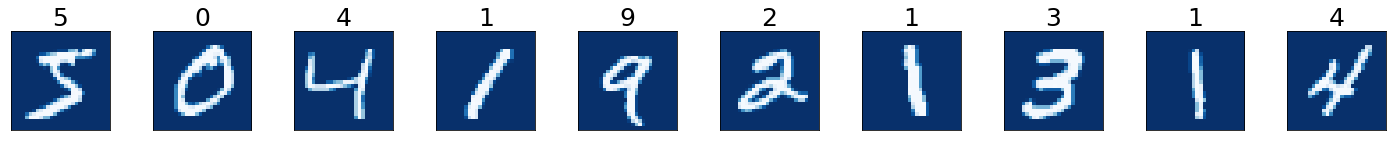

In [28]:
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(train_x[idx], cmap='Blues_r')
    ax.set_title(str(train_y[idx]),fontsize=25)

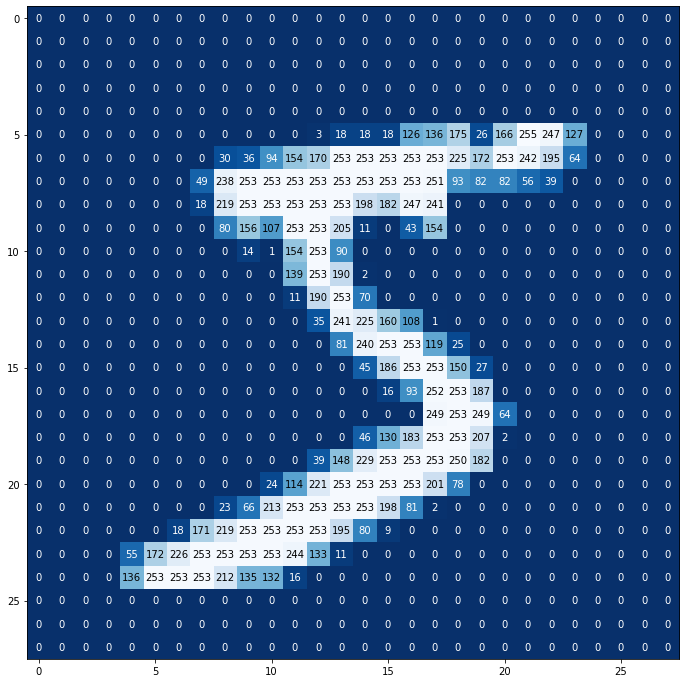

In [29]:
img = train_x[0]

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='Blues_r')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

In [30]:
# Reshape to 2D data
train_x = train_x.reshape(train_x.shape[0], -1)
print(train_x.shape)

sample_size = 5000
# Use only the top 1000 data for training
train_x = pd.DataFrame(train_x[:sample_size, :])
train_y = train_y[:sample_size]

(60000, 784)


## PCA

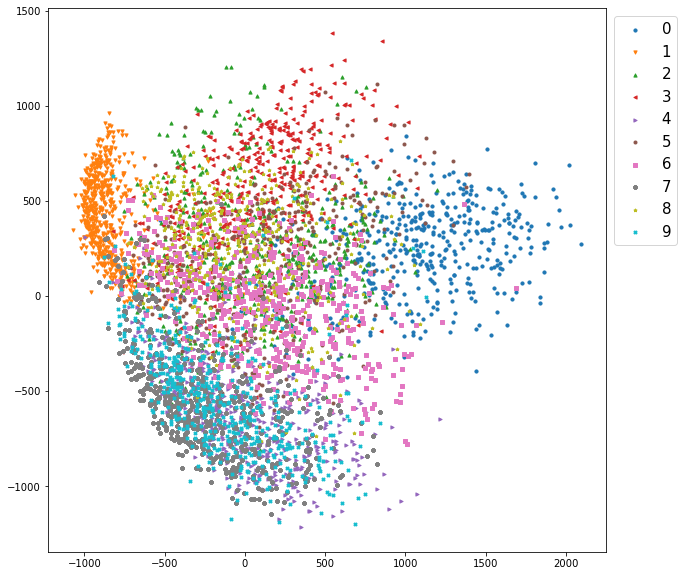

In [31]:
from sklearn.decomposition import PCA

pca = PCA()
x_pca = pca.fit_transform(train_x)
markers=['o','v','^','<','>','8','s','P','*','X']
# plot in 2D by class
plt.figure(figsize=(10,10))
for i,marker in enumerate(markers):
    mask = train_y == i
    plt.scatter(x_pca[mask, 0], x_pca[mask, 1], label=i, s=10, alpha=1,marker=marker)
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left',fontsize=15)

## Truncated SVD

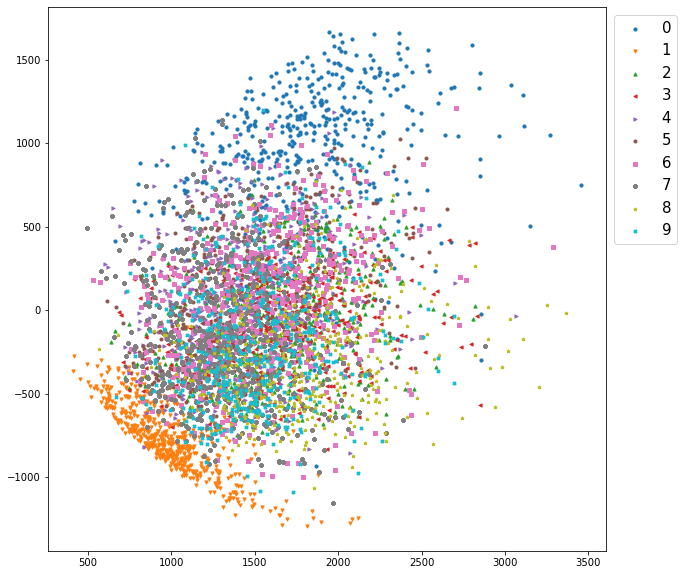

In [32]:
from sklearn.decomposition import TruncatedSVD

tsvd = TruncatedSVD()
x_tsvd = tsvd.fit_transform(train_x)
markers=['o','v','^','<','>','8','s','P','*','X']
# plot in 2D by class
plt.figure(figsize=(10,10))
for i,marker in enumerate(markers):
    mask = train_y == i
    plt.scatter(x_tsvd[mask, 0], x_tsvd[mask, 1], label=i, s=10, alpha=1,marker=marker)
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left',fontsize=15)

## NMF

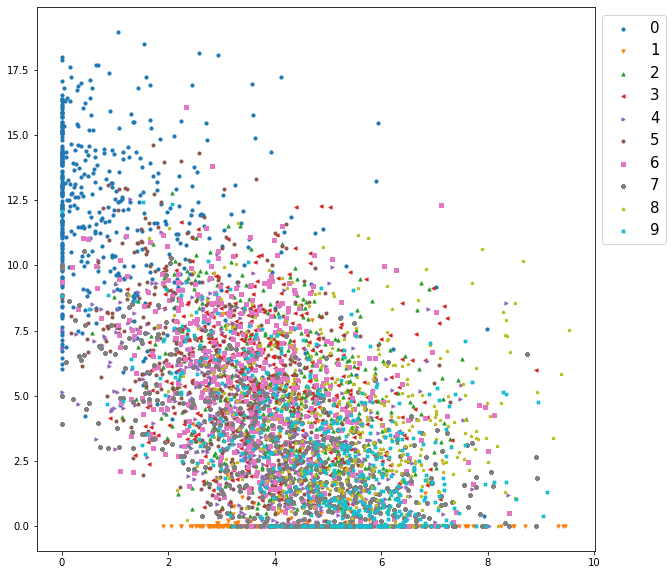

In [33]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=2, init='random', random_state=0)
x_nmf = nmf.fit_transform(train_x)
markers=['o','v','^','<','>','8','s','P','*','X']
# plot in 2D by class
plt.figure(figsize=(10,10))
for i,marker in enumerate(markers):
    mask = train_y == i
    plt.scatter(x_nmf[mask, 0], x_nmf[mask, 1], label=i, s=10, alpha=1,marker=marker)
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left',fontsize=15)

## LDA

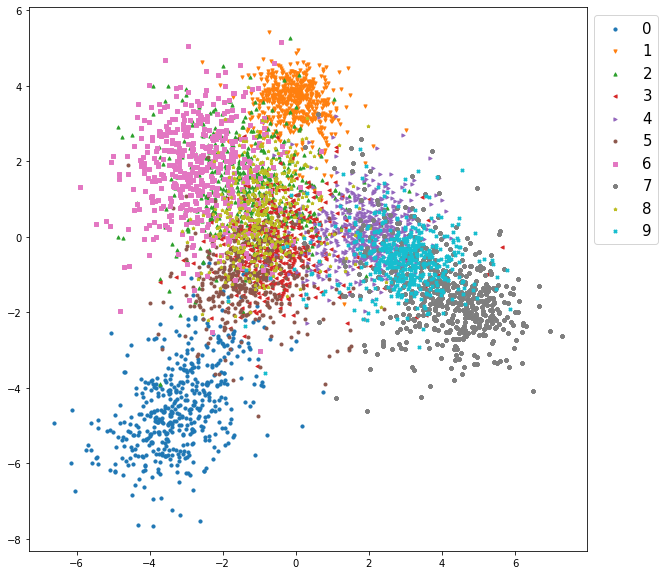

In [34]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
x_lda = lda.fit_transform(train_x, train_y)

plt.figure(figsize=(10,10))
for i,marker in enumerate(markers):
    mask = train_y == i
    plt.scatter(x_lda[mask, 0], x_lda[mask, 1], label=i, s=10, alpha=1,marker=marker)
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left',fontsize=15)

## t-SNE

### - neighboring graph를 base로 하고 local neighbor structure를 보존함 (고차원의 벡터의 유사성이 저차원에서도 유사하도록 보존함)
### - t 분포를 이용해 하나의 기준점을 정하고 모두 다른 데이터와 거리를 구한 후 그 값에 해당하는 t 분포 값을 선택, 값이 유사한 데이터끼리 묶어줌
### - 연산량이 많고 돌릴 때마다 다른 시각화 결과가 나오며 2,3차원으로만 줄일 수 있다는 단점이 있음

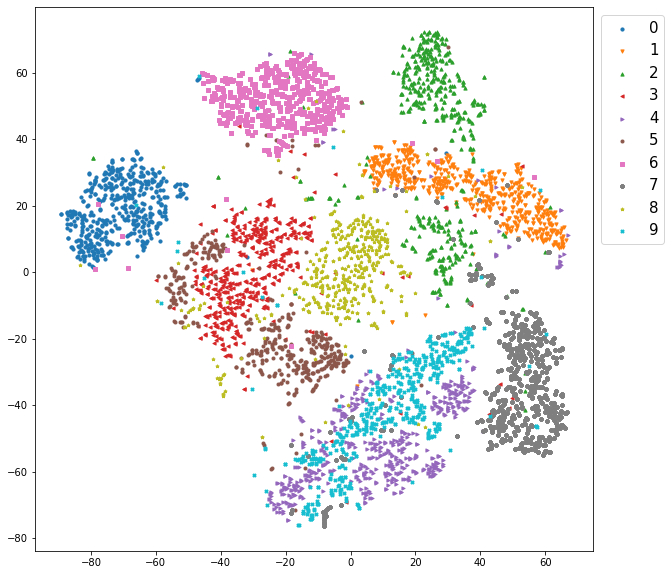

In [35]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
x_tsne = tsne.fit_transform(train_x)

plt.figure(figsize=(10,10))
for i,marker in enumerate(markers):
    mask = train_y == i
    plt.scatter(x_tsne[mask, 0], x_tsne[mask, 1], label=i, s=10, alpha=1,marker=marker)
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left',fontsize=15)

## UMAP

### - neighboring graph를 base로 하며 가장 좋은 성능을 내는 알고리즘으로 알려짐
### - high dimension space에서의 데이터를 graph로 만들고, low dimension으로 graph를 projection함
### -방법-
### 1. data point에서 simplex 복합체로 만들어서 graph를 구성한다
### 2. 각 node에서의 길이 k의 radius를 그린다 (k가 작으면 local structure, 크면 global structure를 가져올 수 있음 -> 이때 겹치는 정도로 connection의 weight를 결정함)
### 3. 이 strength를 그대로 저차원으로 이동시킨게 umap이 된다

### -umap vs pca-
### 차원 수만 입력하면 되는 pca와 달리 umap은 n_neighbors, min_dist 두개의 하이퍼 파라미터가 존재함
### 하이퍼 파라미터가 없다는 점에서 pca가 유용하지만 structure 보존 방면에서 umap이 더 우세함

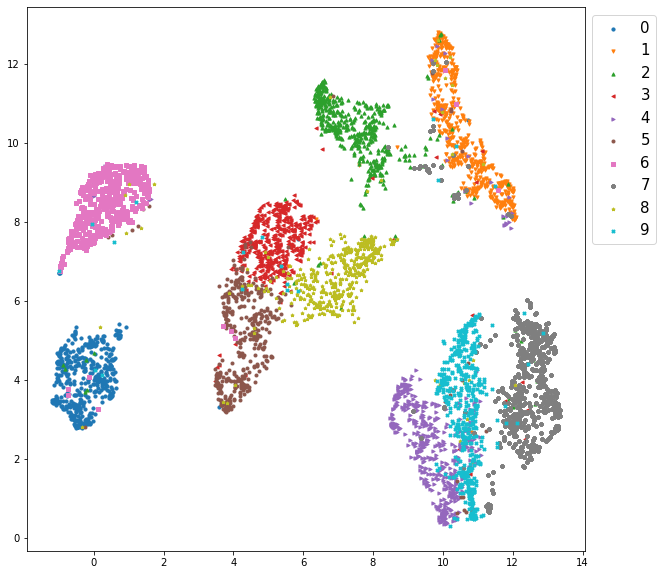

In [38]:
!pip install umap-learn
import warnings
warnings.filterwarnings('ignore')
import umap

um = umap.UMAP()
x_umap = um.fit_transform(train_x)

plt.figure(figsize=(10,10))
for i,marker in enumerate(markers):
    mask = train_y == i
    plt.scatter(x_umap[mask, 0], x_umap[mask, 1], label=i, s=10, alpha=1,marker=marker)
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left',fontsize=15)

  Created wheel for datashape: filename=datashape-0.5.2-py3-none-any.whl size=59454 sha256=c684e982ff6b22d22bb4c4376e93d7adc0095875942366957e9a23c8c4b671e0
  Stored in directory: c:\users\glori\appdata\local\pip\cache\wheels\42\ef\d7\781cf80d4146d76b3d2ed2510113d78c2643c842cc6c22918d
Successfully built datashape


<AxesSubplot:>

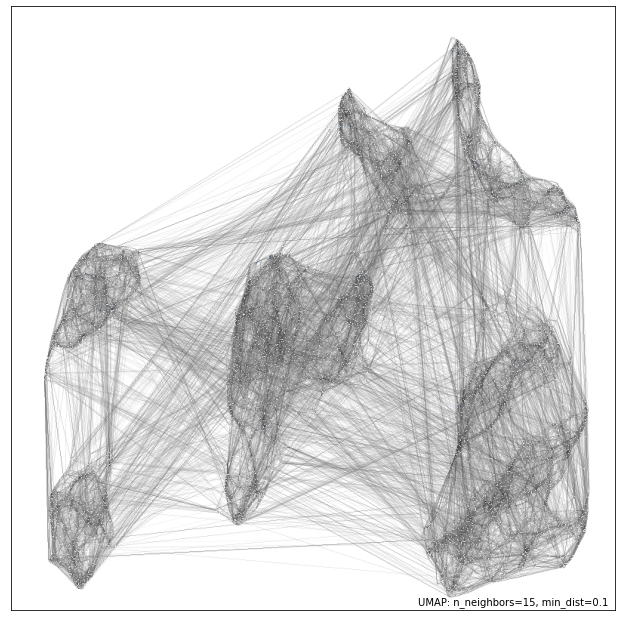

In [40]:
!pip install umap-learn[plot]
import warnings
warnings.filterwarnings('ignore')
import umap.plot
mapper = umap.UMAP().fit(train_x)
umap.plot.connectivity(mapper, show_points=True)

## Another UMAP plot

<AxesSubplot:>

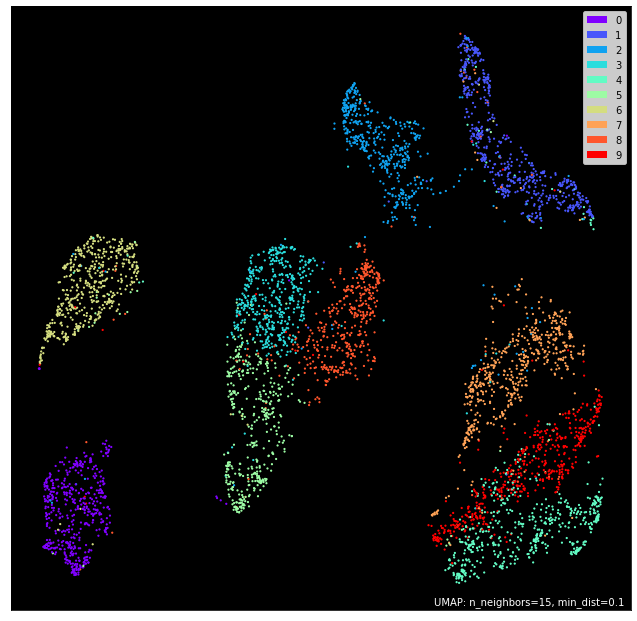

In [41]:
umap.plot.points(mapper, labels=train_y, theme='fire')

## UMAP 3D plot

In [42]:
import plotly
import plotly.express as px
from umap import UMAP

umap_3d = UMAP(n_components=3, init='random', random_state=0)
x_umap = umap_3d.fit_transform(train_x)
umap_df = pd.DataFrame(x_umap)
train_y_sr = pd.Series(train_y,name='label')
print(type(x_umap))
new_df = pd.concat([umap_df,train_y_sr],axis=1)
fig = px.scatter_3d(
    new_df, x=0, y=1, z=2,
    color='label', labels={'color': 'number'}
)
fig.update_traces(marker_size=1)
fig.show()

<class 'numpy.ndarray'>
